In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mimic-clean-text/MIMIC-III-Final_cleaned.csv
/kaggle/input/mimicdata/validation_full.csv
/kaggle/input/mimicdata/test_full.csv
/kaggle/input/mimicdata/vocab.csv
/kaggle/input/mimicdata/train_full.csv
/kaggle/input/mimicdata/ICD_desc_with_freq.csv
/kaggle/input/autoencoderdecoderonpmcembeddingvocab/Vocab.txt
/kaggle/input/pmcmodel/PMC-w2v.bin


In [2]:
data =  pd.read_csv('/kaggle/input/mimic-clean-text/MIMIC-III-Final_cleaned.csv')[:15000]

In [3]:
data.shape, data.columns

((15000, 6),
 Index(['Unnamed: 0', 'TEXT', 'HADM_ID', 'ICD9_CODE', 'clean_text', 'top_ICD'], dtype='object'))

In [4]:
#data['length'] = data.apply(lambda x:len(x['clean_text'].split()) , axis=1)

In [5]:
data.head()

,Unnamed: 0,TEXT,HADM_ID,ICD9_CODE,clean_text,top_ICD
0,0,{Admission Date: [**2117-9-11**] ...,100001.0,"['25013', '3371', '5849', '5780', 'V5867', '25...",admission date discharge date of birth sex nam...,"['25013', '3371', '5849', '5780', 'V5867', '25..."
1,1,{Admission Date: [**2150-4-17**] ...,100003.0,"['53100', '2851', '07054', '5715', '45621', '5...",admission date discharge date of birth sex rec...,"['53100', '2851', '5715', '45621', '53789', '4..."
2,2,{Admission Date: [**2108-4-6**] Dischar...,100006.0,"['49320', '51881', '486', '20300', '2761', '78...",admission date discharge date of birth sex o c...,"['49320', '51881', '486', '20300', '2761', '78..."
3,3,{Admission Date: [**2145-3-31**] ...,100007.0,"['56081', '5570', '9973', '486', '4019']",admission date discharge date of birth sex nam...,"['56081', '5570', '486', '4019']"
4,4,{Admission Date: [**2162-5-16**] ...,100009.0,"['41401', '99604', '4142', '25000', '27800', '...",admission date discharge date of birth sex kno...,"['41401', '99604', '4142', '25000', '27800', '..."


### Create Processed Data for training the bert pytorch model  

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re
import unicodedata
import six
import tensorflow as tf

In [7]:
#!pip install tensorflow==1.14
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")

In [9]:
import re
import numpy as np
import six
import tensorflow as tf

In [10]:
class BasicTokenizer(object):
  """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

  def __init__(self, do_lower_case=True):
    """Constructs a BasicTokenizer.

    Args:
      do_lower_case: Whether to lower case the input.
    """
    self.do_lower_case = do_lower_case

  def tokenize(self, text):
    """Tokenizes a piece of text."""
    text = convert_to_unicode(text)
    text = self._clean_text(text)#perform invalid char removal and whitespace removal

    # This was added on November 1st, 2018 for the multilingual and Chinese
    # models. This is also applied to the English models now, but it doesn't
    # matter since the English models were not trained on any Chinese data
    # and generally don't have any Chinese data in them (there are Chinese
    # characters in the vocabulary because Wikipedia does have some Chinese
    # words in the English Wikipedia.).
    text = self._tokenize_chinese_chars(text)

    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
      if self.do_lower_case:
        token = token.lower()
        token = self._run_strip_accents(token)
      split_tokens.extend(self._run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

  def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
      cat = unicodedata.category(char)
      if cat == "Mn":
        continue
      output.append(char)
    return "".join(output)

  def _run_split_on_punc(self, text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
      char = chars[i]
      if _is_punctuation(char):
        output.append([char])
        start_new_word = True
      else:
        if start_new_word:
          output.append([])
        start_new_word = False
        output[-1].append(char)
      i += 1

    return ["".join(x) for x in output]

  def _tokenize_chinese_chars(self, text):
    """Adds whitespace around any CJK character."""
    output = []
    for char in text:
      cp = ord(char)
      if self._is_chinese_char(cp):
        output.append(" ")
        output.append(char)
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

  def _is_chinese_char(self, cp):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
        (cp >= 0x3400 and cp <= 0x4DBF) or  #
        (cp >= 0x20000 and cp <= 0x2A6DF) or  #
        (cp >= 0x2A700 and cp <= 0x2B73F) or  #
        (cp >= 0x2B740 and cp <= 0x2B81F) or  #
        (cp >= 0x2B820 and cp <= 0x2CEAF) or
        (cp >= 0xF900 and cp <= 0xFAFF) or  #
        (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
      return True

    return False

  def _clean_text(self, text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
      cp = ord(char)
      if cp == 0 or cp == 0xfffd or _is_control(char):
        continue
      if _is_whitespace(char):
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

In [11]:
def load_vocab(vocab_file):
  """Loads a vocabulary file into a dictionary."""
  vocab = collections.OrderedDict()
  index = 0
  #with tf.gfile.GFile(vocab_file, "r") as reader:
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = convert_to_unicode(reader.readline())
      if not token:
        break
      token = (token.strip()).split("\t")
      vocab[token[0]] = index
      index += 1
  print("\nVocab loading done!")
  return vocab

In [12]:
class WordpieceTokenizer(object):
  """Runs WordPiece tokenziation."""

  def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    self.vocab = vocab
    self.unk_token = unk_token
    self.max_input_chars_per_word = max_input_chars_per_word

  def tokenize(self, text):
    """Tokenizes a piece of text into its word pieces.

    This uses a greedy longest-match-first algorithm to perform tokenization
    using the given vocabulary.

    For example:
      input = "unaffable"
      output = ["un", "##aff", "##able"]

    Args:
      text: A single token or whitespace separated tokens. This should have
        already been passed through `BasicTokenizer.

    Returns:
      A list of wordpiece tokens.
    """

    text = convert_to_unicode(text)

    output_tokens = []
    for token in whitespace_tokenize(text):
      chars = list(token)
      if len(chars) > self.max_input_chars_per_word:
        output_tokens.append(self.unk_token)
        #print("\nunknown token inserted")
        continue

      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          if start > 0:
            substr = "##" + substr
          if substr in self.vocab:
            cur_substr = substr
            #print("\nknown token inserted", cur_substr)
            break
          end -= 1
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end

      if is_bad:
        output_tokens.append(self.unk_token)
        #print("\nunknown token inserted") #This is where unknown tokens are being inserted
      else:
        output_tokens.extend(sub_tokens)
    return output_tokens


def _is_whitespace(char):
  """Checks whether `chars` is a whitespace character."""
  # \t, \n, and \r are technically contorl characters but we treat them
  # as whitespace since they are generally considered as such.
  if char == " " or char == "\t" or char == "\n" or char == "\r":
    return True
  cat = unicodedata.category(char)
  if cat == "Zs":
    return True
  return False


def _is_control(char):
  """Checks whether `chars` is a control character."""
  # These are technically control characters but we count them as whitespace
  # characters.
  if char == "\t" or char == "\n" or char == "\r":
    return False
  cat = unicodedata.category(char)
  if cat in ("Cc", "Cf"):
    return True
  return False


def _is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)
  # We treat all non-letter/number ASCII as punctuation.
  # Characters such as "^", "$", and "`" are not in the Unicode
  # Punctuation class but we treat them as punctuation anyways, for
  # consistency.
  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

In [13]:
class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)#Create Vocab dist with index 0
    self.inv_vocab = {v: k for k, v in self.vocab.items()}#Get vocab dict with index as key and token as value
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)#Initialize the basic tokenizer 
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      #for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)

In [14]:
tokenizer = FullTokenizer(
      vocab_file='/kaggle/input/autoencoderdecoderonpmcembeddingvocab/Vocab.txt', do_lower_case=True)


Vocab loading done!


In [15]:
def convert_by_vocab(vocab, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(vocab[item])
  return output


def convert_tokens_to_ids(vocab, tokens):
  return convert_by_vocab(vocab, tokens)


def convert_ids_to_tokens(inv_vocab, ids):
  return convert_by_vocab(inv_vocab, ids)


def whitespace_tokenize(text):
  """Runs basic whitespace cleaning and splitting on a piece of text."""
  text = text.strip()
  if not text:
    return []
  tokens = text.split()
  return tokens

In [16]:
tokenizer.tokenize("\This is the string")

['\\', 'this', 'is', 'the', 'string']

In [17]:
def cleanText(sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = re.sub(r'[0-9]', " ", sentence)
        sentence = re.sub(r'[^\w\s]','',sentence)
        sentence = re.sub(r'(?:^| )\w(?:$| )', ' ', (sentence)).strip()#AKS
        sentence = sentence.lower()
        #return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]
        return sentence

In [18]:
def processTextIntoSentences(text):
    if(not len(text)):
        print("\nGiven string is empty. Please check again")
    sentenceSize  = 125
    #sentenceSize = 256
    line = convert_to_unicode(text)
    line  = cleanText(text)
    tokens = tokenizer.tokenize(line)
    #print("\nTokens", tokens)
    if(tokens):
        all_tokens = [tokens[i: i+sentenceSize] for i in range(0, len(tokens), sentenceSize)]
        #print("\nbatched tokens", len(all_tokens), all_tokens)
        processedTokens = []
        for token_ in all_tokens:
            processedTokens.append(" ".join(token_))
        #print(len(processedTokens[1].split()))
        return ("|".join(processedTokens))
    
            
        

In [19]:
#processTextIntoSentences(a)

In [20]:
data['processedText'] = data.apply(lambda x:processTextIntoSentences(x['clean_text']) , axis=1)

In [21]:
data.shape, data.columns, len((data['processedText'][0]).split('|')[0].split())

((15000, 7),
 Index(['Unnamed: 0', 'TEXT', 'HADM_ID', 'ICD9_CODE', 'clean_text', 'top_ICD',
        'processedText'],
       dtype='object'),
 125)

### Build the vocabulary on training dataset

In [22]:
import pickle
import tqdm
from collections import Counter

In [23]:
((list(data['processedText']))[0])

'admission date discharge date of birth sex name lf surgical or invasive of present poorly controlled type diabetes mellitus htn gastroparesis ckd and retinopathy for orthostatic hypotension date range dka hospitalizations in and d history of worsening nausea vomiting emesis chills and dyspnea on exertion she had fall and hit her right face she also had diarrhea which resolved early last week found to be in ag and bicarb in the ed inital vitals were ra hco anion gap cr baseline she her rd ns insulin srip at on home at in am and at with difficult to control sugars been high given tartrate in ed she was started on an insulin drip at and also aspirin mg po and morphine mg ivx for pain|cxr was clear ekg nad review of systems otherwise negative past medical diabetes mellitis neuropathy nephropathy episodes of dka in and stage iii baseline cr vertebral fracture ejection lives at home in location un with her yo daughter she has no history of etoh tobacco or illicit she is currently unemployed

In [24]:
texts = ''
trainingDocs = list(data['processedText'])
for doc in trainingDocs:
    texts = texts + doc


In [25]:
len(texts.split())

16701963

In [26]:
class TorchVocab(object):
    """Defines a vocabulary object that will be used to numericalize a field.
    Attributes:
        freqs: A collections.Counter object holding the frequencies of tokens
            in the data used to build the Vocab.
        stoi: A collections.defaultdict instance mapping token strings to
            numerical identifiers.
        itos: A list of token strings indexed by their numerical identifiers.
    """

    def __init__(self, counter, max_size=None, min_freq=1, specials=['<pad>', '<oov>'],
                 vectors=None, unk_init=None, vectors_cache=None):
        """Create a Vocab object from a collections.Counter.
        Arguments:
            counter: collections.Counter object holding the frequencies of
                each value found in the data.
            max_size: The maximum size of the vocabulary, or None for no
                maximum. Default: None.
            min_freq: The minimum frequency needed to include a token in the
                vocabulary. Values less than 1 will be set to 1. Default: 1.
            specials: The list of special tokens (e.g., padding or eos) that
                will be prepended to the vocabulary in addition to an <unk>
                token. Default: ['<pad>']
            vectors: One of either the available pretrained vectors
                or custom pretrained vectors (see Vocab.load_vectors);
                or a list of aforementioned vectors
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and
                returns a Tensor of the same size. Default: torch.Tensor.zero_
            vectors_cache: directory for cached vectors. Default: '.vector_cache'
        """
        self.freqs = counter
        counter = counter.copy()
        min_freq = max(min_freq, 1)

        self.itos = list(specials)
        # frequencies of special tokens are not counted when building vocabulary
        # in frequency order
        for tok in specials:
            del counter[tok]

        max_size = None if max_size is None else max_size + len(self.itos)

        # sort by frequency, then alphabetically
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:
                break
            self.itos.append(word)

        # stoi is simply a reverse dict for itos
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.vectors = None
        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init, cache=vectors_cache)
        else:
            assert unk_init is None and vectors_cache is None

    def __eq__(self, other):
        if self.freqs != other.freqs:
            return False
        if self.stoi != other.stoi:
            return False
        if self.itos != other.itos:
            return False
        if self.vectors != other.vectors:
            return False
        return True

    def __len__(self):
        return len(self.itos)

    def vocab_rerank(self):
        self.stoi = {word: i for i, word in enumerate(self.itos)}

    def extend(self, v, sort=False):
        words = sorted(v.itos) if sort else v.itos
        for w in words:
            if w not in self.stoi:
                self.itos.append(w)
                self.stoi[w] = len(self.itos) - 1


class Vocab(TorchVocab):
    def __init__(self, counter, max_size=None, min_freq=1):
        self.pad_index = 0
        self.unk_index = 1
        self.eos_index = 2
        self.sos_index = 3
        self.mask_index = 4
        super().__init__(counter, specials=["<pad>", "<unk>", "<eos>", "<sos>", "<mask>"],
                         max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentece, seq_len, with_eos=False, with_sos=False) -> list:
        pass

    def from_seq(self, seq, join=False, with_pad=False):
        pass

    @staticmethod
    def load_vocab(vocab_path: str) -> 'Vocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)


# Building Vocab with text files
class WordVocab(Vocab):
    def __init__(self, texts, max_size=None, min_freq=1):
        print("Building Vocab")
        counter = Counter()
        count = 0
        words = ((texts.replace("\n", "").replace("\t", "")).replace("|"," ")).split()
        for word in words:
            counter[word] += 1
            count += 1
        print("\nTotal line", count)
        super().__init__(counter, max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentence, seq_len=None, with_eos=False, with_sos=False, with_len=False):
        if isinstance(sentence, str):
            sentence = sentence.split()

        seq = [self.stoi.get(word, self.unk_index) for word in sentence]

        if with_eos:
            seq += [self.eos_index]  # this would be index 1
        if with_sos:
            seq = [self.sos_index] + seq

        origin_seq_len = len(seq)

        if seq_len is None:
            pass
        elif len(seq) <= seq_len:
            seq += [self.pad_index for _ in range(seq_len - len(seq))]
        else:
            seq = seq[:seq_len]

        return (seq, origin_seq_len) if with_len else seq

    def from_seq(self, seq, join=False, with_pad=False):
        words = [self.itos[idx]
                 if idx < len(self.itos)
                 else "<%d>" % idx
                 for idx in seq
                 if not with_pad or idx != self.pad_index]

        return " ".join(words) if join else words

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

In [27]:
newvocab = WordVocab(texts,100000,1)

Building Vocab

Total line 16829108


In [28]:
type(newvocab.stoi)

dict

In [29]:
with open('vocabOn30k2minFreqNew.txt' , 'w') as f:
    for key, val in (newvocab.stoi).items():
        f.write("%s\t%s\n"%(key,val))

In [30]:
newvocab.save_vocab('vocabOn30k2minfreqNew.txt')

In [31]:
vocab = WordVocab.load_vocab('vocabOn30k2minfreqNew.txt')
len(newvocab.stoi)

39382

In [32]:
#with open('vocabOn30k2minfreqNew.txt', "rb") as f:
    #print(len(f))

In [33]:
#newvocab.counter

In [34]:
data['processedText'][0]

'admission date discharge date of birth sex name lf surgical or invasive of present poorly controlled type diabetes mellitus htn gastroparesis ckd and retinopathy for orthostatic hypotension date range dka hospitalizations in and d history of worsening nausea vomiting emesis chills and dyspnea on exertion she had fall and hit her right face she also had diarrhea which resolved early last week found to be in ag and bicarb in the ed inital vitals were ra hco anion gap cr baseline she her rd ns insulin srip at on home at in am and at with difficult to control sugars been high given tartrate in ed she was started on an insulin drip at and also aspirin mg po and morphine mg ivx for pain|cxr was clear ekg nad review of systems otherwise negative past medical diabetes mellitis neuropathy nephropathy episodes of dka in and stage iii baseline cr vertebral fracture ejection lives at home in location un with her yo daughter she has no history of etoh tobacco or illicit she is currently unemployed

In [35]:
!pip install torch 

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

In [37]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [38]:
#!pip install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [39]:
class SegmentEmbedding(nn.Embedding):
    def __init__(self, embed_size=512):
        super().__init__(3, embed_size, padding_idx=0)

In [40]:
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=256):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [41]:
#newvocab.stoi.keys()


In [42]:
word_model = KeyedVectors.load_word2vec_format("/kaggle/input/pmcmodel/PMC-w2v.bin", binary=True)
print('Found %s word vectors.' % len(word_model.index_to_key))
print(word_model['Cholera'].shape)
matrix_len = len(newvocab.stoi)
weights_matrix = np.zeros((matrix_len, 200))
words_found = 0

for word, i in (newvocab.stoi.items()):
    try: 
        weights_matrix[i] = word_model[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(200, ))
print('words not found',len(newvocab.stoi)- words_found, weights_matrix.shape )
weights_matrix

Found 2515686 word vectors.
(200,)
words not found 4878 (39382, 200)


array([[-0.41679911, -0.44827412,  0.0062554 , ...,  0.10389439,
         0.10569827, -0.25466945],
       [-0.44798994,  0.29155425,  0.05798534, ...,  0.04734979,
        -0.11857151, -0.64839596],
       [ 0.06657456, -0.55123331, -0.00772842, ..., -0.68149277,
        -0.5585603 ,  0.44378112],
       ...,
       [-0.01128049,  0.00835382,  0.19846411, ...,  0.02915942,
        -0.19766344, -0.06584377],
       [ 0.00479148,  0.01465072,  0.03300364, ...,  0.01149676,
        -0.02512572, -0.00507415],
       [-0.27513109, -1.262989  ,  0.67804741, ...,  0.45248325,
        -0.55666055,  1.08158507]])

In [43]:
def create_emb_layer(src_vocab_size,embed_size,non_trainable=False):
    #num_embeddings, embedding_dim = weights_matrix.shape()
    emb_layer = nn.Embedding(src_vocab_size, embed_size)
    #emb_layer.load_state_dict({'weight': weights_matrix})
    emb_layer.weight=nn.Parameter(torch.tensor(weights_matrix,dtype=torch.float32))
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [44]:
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

In [45]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        #self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.token = create_emb_layer(vocab_size,embed_size )
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

In [46]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [47]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))


In [48]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [49]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


In [50]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [51]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


In [52]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [53]:
class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # torch.ByteTensor([batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

In [54]:
bert = BERT(len(vocab), hidden=200, n_layers=8, attn_heads=5)

In [55]:
class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.hidden)
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x)#, self.mask_lm(x) 


class NextSentencePrediction(nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x[:, 0]))


class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

In [56]:
cuda_condition = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_condition else "cpu")

In [57]:
model = BERTLM(bert, len(vocab)).to(device)

In [58]:
#model

In [59]:
from torch.utils.data import Dataset
import tqdm
import torch
import random

In [60]:
### Preparing Dataset and Dataloadrer 

In [61]:
icdCodeDescription  = '/kaggle/input/mimicdata/ICD_desc_with_freq.csv'
topCodes  = 2833
icdCodes = pd.read_csv(icdCodeDescription)[:topCodes]
icdCodeDescDict = {}
codes  = list(icdCodes["Code"])
Desc  = list(icdCodes["Long Description"])
code2Index = {}
for i , code in enumerate(codes):
    icdCodeDescDict[code] = Desc[i]
    code2Index[code] = i+1
#return icdCodeDescDict,code2Index

In [62]:
len(icdCodeDescDict)

2833

In [63]:
data.columns

Index(['Unnamed: 0', 'TEXT', 'HADM_ID', 'ICD9_CODE', 'clean_text', 'top_ICD',
       'processedText'],
      dtype='object')

In [64]:
def CreateTextFileLableMap():
    trueLabels = list(data['ICD9_CODE'])
    textFileLabel = {}
    for i , trueLabel in enumerate(trueLabels):
        textFileLabel[i+1]  = [y for y in trueLabel[2:-2].split("', '")if y in  icdCodeDescDict]
    return textFileLabel

In [65]:
label = CreateTextFileLableMap()

In [66]:
label[1]

['25013',
 '3371',
 '5849',
 '5780',
 'V5867',
 '25063',
 '5363',
 '4580',
 '25043',
 '40390',
 '5853',
 '25053',
 '36201',
 '25083',
 '7078',
 'V1351']

In [67]:
listIds = [i for i in range(data.shape[0])]

In [68]:
len(listIds)

15000

In [69]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = data['processedText'][ID]
        y = self.labels[ID]
        return X, y

In [70]:
dataset = Dataset(listIds,label )

In [71]:
 dataset[1]

('admission date discharge date of birth sex recorded as having no known allergies to name lf ground surgical or invasive ij of present known is m hepc cirrhosis cb grade iii and portal gastropathy last egd who emesis and melena days pt was in his until about days pta when he intermittent nausea he had episodes emesis and episode of tarry black stool in of admission he reports some lightheadedness which new but denies frank hematemesis abdominal chills significant increases in his abdominal girth drinking or medication noncompliance he also naproxen for back pain times day in the in the ed his vitals were on ra given ns iv protonix mg iv started on an he had guaiac positive brown stool on rectal exam he|by the liver fellow in the ed who felt this was unlikely bleed and recommended work up for infection an ng attempted however patient was unable to tolerate it in abdominal ultrasound was done which showed patent scant ascites but not enough to tap bp dropped to pt transferred to micu fo

In [72]:
len(dataset[1][0].split("|")[4].split())

125

In [73]:
class BERTDataset(Dataset):
    def __init__(self,vocab, seq_len, list_IDs, labels, encoding="utf-8", on_memory=True):
        self.vocab = vocab
        self.seq_len = seq_len

        self.on_memory = on_memory
        #self.corpus_lines = corpus_lines
        self.list_IDs  = list_IDs 
        self.encoding = encoding
        self.labels = labels
        self.texts  = data['processedText']


    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, item):# if item count start from 1 and till the size of docuemts length 
        text_ = self.texts[item-1]
        text_ = text_.split('|')
        if(len(text_) % 2):
            text_.append(text_[-1])
        text_ = [text_[i: i+2] for i in range(0, len(text_), 2)]
        #print(len(text_))
        bert_input_ = self.generateTensor(text_)
        return bert_input_
        #return {key: torch.tensor(value) for key, value in output.items()}
    def generateTensor(self, text):
        numberOfLines  = len(text)
        bert_input_ = []
        bert_label_ = []
        segment_label_ = []
        is_next_ = []
        for i in range(numberOfLines):
            t1, t2, is_next_label = self.random_sent(i, text)#generate the label for next sentence prediction in the form of 0 or 1
            t1_random, t1_label = self.random_word(t1)#This will generate the masked token for sentence A and the label index for the masked token 
            t2_random, t2_label = self.random_word(t2)

        # [CLS] tag = SOS tag, [SEP] tag = EOS tag
            t1 = [self.vocab.sos_index] + t1_random + [self.vocab.eos_index]
            t2 = t2_random + [self.vocab.eos_index]

            t1_label = [self.vocab.pad_index] + t1_label + [self.vocab.pad_index]
            t2_label = t2_label + [self.vocab.pad_index]

            segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
            bert_input = (t1 + t2)[:self.seq_len]
            bert_label = (t1_label + t2_label)[:self.seq_len]

            padding = [self.vocab.pad_index for _ in range(self.seq_len - len(bert_input))]#This would pad the input, output lable and sengement label up to the maximum length
            bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)
            bert_input_.append(bert_input)
            bert_label_.append(bert_label)
            segment_label_.append(segment_label)
            is_next_.append(is_next_label)
        return ([torch.tensor(bert_input_),torch.tensor(bert_label_),torch.tensor(segment_label_), torch.tensor(is_next_)])
    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []

        for i, token in enumerate(tokens):
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8:
                    tokens[i] = self.vocab.mask_index

                # 10% randomly change token to random token
                elif prob < 0.9:
                    tokens[i] = random.randrange(len(self.vocab))

                # 10% randomly change token to current token
                else:
                    tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)

                output_label.append(self.vocab.stoi.get(token, self.vocab.unk_index))

            else:
                tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)
                output_label.append(0)

        return tokens, output_label

    def random_sent(self, index,text):
        t1, t2 = self.get_corpus_line(index,text)

        # output_text, label(isNotNext:0, isNext:1)
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, t2, 1 #0

    def get_corpus_line(self, item,text):
        if self.on_memory:
            return text[item][0], text[item][1]
        """else:
            line = self.file.__next__()
            if line is None:
                self.file.close()
                self.file = open(self.corpus_path, "r", encoding=self.encoding)
                line = self.file.__next__()

            t1, t2 = line[:-1].split("\t")
            return t1, t2"""

    def get_random_line(self,text):
        if self.on_memory:
            return text[random.randrange(len(text))][1]

In [74]:
train_data = BERTDataset(newvocab,256, listIds,label )

In [75]:
#a  = data['processedText'][0]

In [76]:
train_data[1][0].shape, len(train_data[1])

(torch.Size([4, 256]), 4)

In [77]:
import argparse


In [78]:
parser = argparse.ArgumentParser()
parser.add_argument("-hs", "--hidden", type=int, default=512, help="hidden size of transformer model")
parser.add_argument("-l", "--layers", type=int, default=8, help="number of layers")
parser.add_argument("-a", "--attn_heads", type=int, default=8, help="number of attention heads")
parser.add_argument("-s", "--seq_len", type=int, default=20, help="maximum sequence len")

parser.add_argument("-b", "--batch_size", type=int, default=64, help="number of batch_size")
parser.add_argument("-e", "--epochs", type=int, default=10, help="number of epochs")
parser.add_argument("-w", "--num_workers", type=int, default=5, help="dataloader worker size")
parser.add_argument("-steps", "--warm_up_step", type=int, default=1000, help="dataloader worker size")

parser.add_argument("--with_cuda", type=bool, default=True, help="training with CUDA: true, or false")
parser.add_argument("--log_freq", type=int, default=10, help="printing loss every n iter: setting n")
parser.add_argument("--corpus_lines", type=int, default=None, help="total number of lines in corpus")
parser.add_argument("--cuda_devices", type=int, nargs='+', default=None, help="CUDA device ids")
parser.add_argument("--on_memory", type=bool, default=True, help="Loading on memory: true or false")

parser.add_argument("--lr", type=float, default=1e-3, help="learning rate of adam")
parser.add_argument("--adam_weight_decay", type=float, default=0.01, help="weight_decay of adam")
parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam first beta value")
args = parser.parse_args("")

In [79]:
betas=(0.9, 0.999)


In [80]:
args

Namespace(adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, attn_heads=8, batch_size=64, corpus_lines=None, cuda_devices=None, epochs=10, hidden=512, layers=8, log_freq=10, lr=0.001, num_workers=5, on_memory=True, seq_len=20, warm_up_step=1000, with_cuda=True)

### Define model hyper parameter

In [81]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [82]:
from torch.optim import Adam
optim = Adam(model.parameters(), lr=args.lr, betas=betas, weight_decay=args.adam_weight_decay)
optim_schedule = ScheduledOptim(optim, args.hidden, n_warmup_steps=args.warm_up_step)
#criterion = nn.NLLLoss(ignore_index=0)
#log_freq = args.log_freq

In [83]:
model.parameters()
criterion = nn.NLLLoss(ignore_index=0)


In [84]:
avg_loss = 0.0
total_correct = 0
total_element = 0

In [85]:
sampleData = train_data[1]

In [86]:
sampleData[0].shape

torch.Size([4, 256])

In [87]:
#model.train()

In [88]:
#(sampleData[2][3:4,:])

In [89]:
#next_sent_output, mask_lm_output = model.forward(sampleData[0].to(device), sampleData[2].to(device))

In [90]:
#next_sent_output.shape, mask_lm_output.shape

In [91]:
len(train_data)

15000

In [92]:
import random
docIdxs = [i+1 for i in range(len(train_data))]
loss_val = []

In [93]:
import time
epochs = 50
for epoch in range(epochs):
    print('Training for epoch ',epoch+1)
    random.shuffle(docIdxs)
    start = time.time()
    codeCount =0
    for docIdx in docIdxs:
        trainTensors = train_data[docIdx]
        #next_sent_output, mask_lm_output = model.forward(trainTensors[0].to(device), trainTensors[2].to(device))
        next_sent_output= model.forward(trainTensors[0].to(device), trainTensors[2].to(device))
        next_loss = criterion(next_sent_output, trainTensors[3].to(device))
        #mask_loss = criterion(mask_lm_output.transpose(1, 2), trainTensors[1].to(device))
        #loss =  mask_loss + next_loss
        loss = next_loss
        codeCount +=1
        if(codeCount+10000)%10000 ==0:
            print(codeCount)
        if True:
                optim_schedule.zero_grad()
                loss.backward()
                optim_schedule.step_and_update_lr()
        # next sentence prediction accuracy
        #correct = next_sent_output.argmax(dim=-1).eq(trainTensors[3].to(device)).sum().item()
        avg_loss += (loss.item())/trainTensors[0].shape[0]
        #total_correct += correct
        total_element += trainTensors[3].nelement()
    #print("avg_acc",(total_correct / (total_element ))* 100)
    print("avg_loss", avg_loss / (epoch + 1))
    loss_val.append((avg_loss / (epoch + 1) )/len(train_data))
    if((epoch+3) % 3==0):
        torch.save(model.state_dict(), str(epoch)+'_model_weights.pth')
        torch.save(model, str(epoch)+'_bertML.model')
    print("loss val", loss_val)


Training for epoch  1
10000
avg_loss 7.701119273222654
loss val [0.000513407951548177]
Training for epoch  2
10000
avg_loss 4.629200781467428
loss val [0.000513407951548177, 0.0003086133854311618]
Training for epoch  3
10000
avg_loss 3.6046374673283648
loss val [0.000513407951548177, 0.0003086133854311618, 0.00024030916448855764]
Training for epoch  4
10000
avg_loss 3.0958640383093816
loss val [0.000513407951548177, 0.0003086133854311618, 0.00024030916448855764, 0.0002063909358872921]
Training for epoch  5
10000
avg_loss 2.7871143460692815
loss val [0.000513407951548177, 0.0003086133854311618, 0.00024030916448855764, 0.0002063909358872921, 0.00018580762307128545]
Training for epoch  6
10000
avg_loss 2.5819540553274805
loss val [0.000513407951548177, 0.0003086133854311618, 0.00024030916448855764, 0.0002063909358872921, 0.00018580762307128545, 0.00017213027035516536]
Training for epoch  7
10000
avg_loss 2.43682072885813
loss val [0.000513407951548177, 0.0003086133854311618, 0.00024030916

In [94]:
loss_val

[0.000513407951548177,
 0.0003086133854311618,
 0.00024030916448855764,
 0.0002063909358872921,
 0.00018580762307128545,
 0.00017213027035516536,
 0.00016245471525720866,
 0.0001551177053374702,
 0.00014942085080498822,
 0.00014489175689080423,
 0.00014114274629947632,
 0.0001380689969887253,
 0.00013543193507413304,
 0.00013314374092026425,
 0.00013113320748951108,
 0.00012939103051776602,
 0.0001278506399860831,
 0.00012644430148392997,
 0.00012524207264290248,
 0.000124159077154559,
 0.00012315318088204996,
 0.0001222942994313937,
 0.00012149242672883001,
 0.00012075572172167893,
 0.00012007101316256377,
 0.00011941898414121351,
 0.00011882773034600898,
 0.00011829782519871787,
 0.00011781645441831068,
 0.00011734707825000402,
 0.00011691822615876897,
 0.00011649263763852668,
 0.00011612719841856804,
 0.00011579187968923312,
 0.00011542307742741467,
 0.00011511196943581731,
 0.00011482850653930266,
 0.00011452311179444508,
 0.00011423384414893374,
 0.00011396325680007591,
 0.0001136

In [95]:
print((time.time()-start)/60)

9.728822465737661


In [96]:
torch.save(model, str(epochs)+'_bertML.model')

In [97]:
torch.save(model.state_dict(), str(epochs)+'_model_weights.pth')

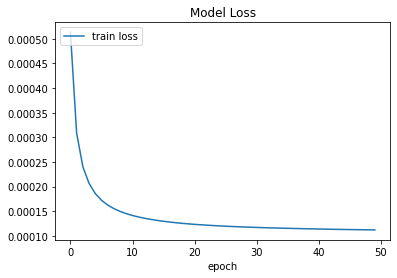

In [98]:
# summarize history for model loss
import matplotlib.pyplot as plt
plt.plot(loss_val)
#plt.plot(train_history1.history['val_loss'])
plt.title('Model Loss')
#plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()
#plt.savefig('Loss_trainVsValidation.png', bbox_inches='tight', dpi = 300)